In [1]:
import mph
import matplotlib.pyplot as plt

import pyro
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS

import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt
import seaborn as sns

import graphviz
import sys
sys.path.append('../')
import utils

In [2]:

freqValues = [[117.5,122.5,0.5],[645.5,650.5,0.5],[1597.5,1600.5,0.5], [2977.5,2981.5,0.5]]
freqVal = utils.createComsolVector("lin", freqValues, param="step", display=False).astype(int)
print(freqVal*2)

Command copied in the clipboard.
Total number of data points: 38
Press ctrl+v to paste it

[ 234  236  236  238  238  240  240  242  242  244  244 1290 1292 1292
 1294 1294 1296 1296 1298 1298 1300 1300 3194 3196 3196 3198 3198 3200
 3200 5954 5956 5956 5958 5958 5960 5960 5962 5962]


In [2]:

freqValues = [[117.5,122.5,1],[645.5,650.5,1],[1597.5,1600.5,1], [2977.5,2981.5,1]]
freqVal = utils.createComsolVector("lin", freqValues, param="step", display=False).astype(int)
# Importing measured data

files = ["centerFreqResponse"]#, "center2FreqResponse", "randomFreqResponse"]
Y_exp = np.array([])
for file in files:
    experiment = pd.read_csv("../Data/bend/"+file+".csv")
    # Mobility value calculated from input data and converted to torch
    mobility = abs(experiment["force"].values + 1j*experiment["velocity"].values)
    Y_exp = np.append(Y_exp, abs(mobility[[freqVal*2]]))
    #self.Y_exp_norm = (self.Y_exp - self.Y_exp.mean()) / self.Y_exp.std() # Normalization
    freq = torch.tensor(experiment["freq"].values) # Freq values(x axis) converted to torch
meas = pd.read_csv("../Data/bend/centerFreqResponse.csv")
mobility = abs(meas["force"].values + 1j*meas["velocity"].values)

Command copied in the clipboard.
Total number of data points: 21
Press ctrl+v to paste it



In [3]:
client = mph.start()
model = client.load("../comsol/testComsol.mph")


In [5]:
model.parameters()
def updateParam(model, young=1, rho=1, eta=1):
    model.parameter('youngs', str(10.0537524e10)+' [Pa]')
    model.parameter('density', str(8183.2602)+' [kg/m^3]')
    model.parameter('eta', str(0.0154)+' [Pa]')

updateParam(model, young=0.996, rho=1, eta=0.01)
model.parameters()

{'youngs': '100537524000.0 [Pa]',
 'density': '8183.2602 [kg/m^3]',
 'eta': '0.0154 [Pa]',
 'F0': '1 [N]',
 'Youngs': '100537524000.0 [Pa]',
 'damping': '0.0154 [Pa]'}

In [6]:

model.solve("Study 2")
comsolResults = abs(model.evaluate('comp1.point2'))
experiment = pd.read_csv("../Data/bend/centerFreqResponse.csv")[20:]
# Mobility value calculated from input data and converted to torch
mobility = abs(experiment["force"].values + 1j*experiment["velocity"].values)
Y_exp = mobility
# self.Y_exp.append(abs(mobility))#[self.freqVal*2]))
#self.Y_exp_norm = (self.Y_exp - self.Y_exp.mean()) / self.Y_exp.std() # Normalization
freq = experiment["freq"].values

In [12]:
np.arange(50, 3000.5, 0.5)


array([  50. ,   50.5,   51. , ..., 2999. , 2999.5, 3000. ])

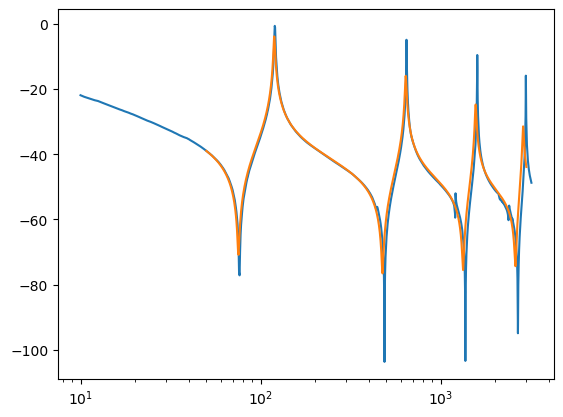

In [14]:
plt.plot(freq, 20*np.log10(Y_exp))
plt.plot(np.arange(50, 3000.5, 0.5), 20*np.log10(comsolResults))
plt.xscale("log")

In [5]:
def model_YoungDampingDensity(x, y_obs):
    # Density definition
    #rho_mean = pyro.param("rho_mean", dist.Normal(1., 0.5), constraint=constraints.real)
    #rho_var = pyro.param("rho_var", dist.Cauchy(1., 0.), constraint=constraints.positive)
    rho = pyro.sample("rho", dist.Normal(1., 0.25))
    # Damping loss factor definition
    """
    eta_mean = pyro.param("eta_mean", dist.Normal(1., .2), constraint=constraints.positive)
    eta_var = pyro.param("eta_var", dist.Cauchy(0., .5))
    """
    eta = pyro.sample("eta", dist.Normal(1., 0.25))
    # Young's modulus definition
    #E_mean = pyro.param("E_mean", dist.Normal(0.99, .5), constraint=constraints.positive)
    #E_var = pyro.param("E_var", dist.Cauchy(1., 0.), constraint=constraints.positive)
    E = pyro.sample("E", dist.Normal(1., 0.01))
    # Since the studio is done frequcuency by frequency, the loop can't be vectorized like: "with pyro.plate......"
    y = torch.zeros(len(y_obs))
    with pyro.plate("data", len(y_obs)):
        #updateParam(model, young=E.detach().numpy(), rho=rho.detach().numpy(), eta=eta.detach().numpy(), freq=x[i])

        updateParam(model, young=E.detach().numpy(), rho=rho.detach().numpy())
        model.solve("Study 3")
        comsolResults = abs(model.evaluate('comp1.point1'))
        #print(y_obs[i])
        y = pyro.sample("y", dist.Normal(torch.tensor(comsolResults), 0.5), obs=y_obs)
    return y

## Exact inference

In [6]:

pyro.clear_param_store()
y_obs = Y_exp# Suppose this was the vector of observed y's
input_x = freqVal
pyro.render_model(model_YoungDampingDensity, model_args=(input_x, torch.tensor(y_obs)), render_distributions=True)

nuts_kernel = NUTS(model_YoungDampingDensity)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=10, num_chains=1)        
mcmc.run(input_x, torch.tensor(y_obs))

# Show summary of inference results
mcmc.summary()
posterior_samples = mcmc.get_samples()


sns.displot(posterior_samples["E"]*10e10)
plt.xlabel("Young's modulus values")
plt.show()
        
sns.displot(posterior_samples["rho"]*10e10)
plt.xlabel("density values")
plt.show()

Sample:  14%|█▎        | 15/110 [8:14:43, 1763.09s/it, step size=3.09e-03, acc. prob=0.365]

KeyboardInterrupt: 

In [32]:
updateParam(model, young=1, rho=1)
model.solve("Study 3")
comsolResults = abs(model.evaluate('comp1.point1'))
# range of values used for the comsol studio
# range(10, 10, 470) range(470, 1, 520) range(520, 5, 600) range(600, 1,700) range(700, 10,1350) range(1350,1, 1390) range(1390,20,1570) range(1570,1,1630) range(1630,100,2650) range(2650,1,2750) range(2750, 20 ,2950) range(2950, 1, 3050)

## Variational inference

In [33]:
from pyro.optim import Adam

pyro.clear_param_store()
y_obs = Y_exp# Suppose this was the vector of observed y's
input_x = freqVal
#pyro.render_model(model_YoungDampingDensity, model_args=(input_x, torch.tensor(y_obs)), render_distributions=True)

# Defining optimizeer
adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)

nuts_kernel = NUTS(model_YoungDampingDensity)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=10, num_chains=1)        
mcmc.run(input_x, torch.tensor(y_obs))

# Show summary of inference results
mcmc.summary()
posterior_samples = mcmc.get_samples()


sns.displot(posterior_samples["E"]*10e10)
plt.xlabel("Young's modulus values")
plt.show()
        
sns.displot(posterior_samples["rho"]*10e10)
plt.xlabel("density values")
plt.show()

array([1.43188632, 5.17247802, 0.98652631, 0.54271964, 0.37580206,
       0.28832876, 0.23448936, 0.19801089, 0.17165904, 0.15172836,
       0.1361246 , 0.11912321, 0.11079963, 0.1035894 , 0.09728323,
       0.09172118, 0.08677889, 0.08235824, 0.07838079, 0.07478304,
       0.07151309, 0.06852807, 0.05282683, 0.05091879, 0.0491489 ,
       0.0475027 , 0.04596766, 0.04453291, 0.04318893, 0.03009313,
       0.02935285, 0.02864992, 0.02798159, 0.02734537, 0.026739  ,
       0.02616044, 0.02560782, 0.02507943])

In [31]:
range(117.50,0.50,122.50) range(645.50,0.50,650.50) range(1597.50,0.50,1600.50) range(2977.50,0.50,2981.50) 

SyntaxError: invalid syntax (3978514635.py, line 1)

In [11]:
for arch in architectures['Darwin']:
            comsol = root/'bin'/arch/'comsol'
            if comsol.is_file():
                print("here")
                break

NameError: name 'architectures' is not defined

In [14]:
updateParam(model, young=0.9, rho=1.1)
model.solve("Study 3")
comsolResults = abs(model.evaluate('comp1.point1'))

In [9]:
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS

import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt
import seaborn as sns

import graphviz
def updateParam(model, young=10e10, rho=8.34e3, eta=0.01):
    model.parameter('Youngs', str(young)+' [Pa]')
    model.parameter('density', str(rho)+' [kg/m^3]')
    model.parameter('damping', str(eta)+' [Pa]')

def modelTest():
    E_mean = pyro.param("E_mean", dist.Normal(1, 3.))
    E_var = pyro.param("E_var", dist.Cauchy(1., 0.))
    E = pyro.sample("E", dist.Normal(E_mean, E_var))
    print("running iterations")
    with pyro.plate("data", y_obs.shape[1]):
        updateParam(model, young=E)
        model.solve("Study 3")
        y_values = model.evaluate('comp1.point1')
        y = pyro.sample("y", dist.Normal(y_values, 1.), )
    return y

pyro.clear_param_store()
pyro.render_model(modelTest, render_distributions=True)

freq = pd.read_csv(".Data/bend/pointTableComsol.csv")

nuts_kernel = NUTS(modelTest)
mcmc = MCMC(nuts_kernel, warmup_steps=2, num_chains=1)        
mcmc.run()

# Show summary of inference results
mcmc.summary()
posterior_samples = mcmc.get_samples()

sns.displot(posterior_samples["E"]*10e10)
plt.xlabel("Young's modulus values")
plt.show()
        
sns.displot(posterior_samples["rho"]*10e10)
plt.xlabel("density values")
plt.show()
return

running iterations


NameError: name 'y_obs' is not defined

In [14]:
freq = pd.read_csv("./Data/bend/pointTableComsol.csv")


In [15]:
freq['% Model'][4:].values

array(['10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110',
       '120', '130', '140', '150', '160', '170', '180', '190', '200',
       '210', '220', '230', '240', '250', '260', '270', '280', '290',
       '300', '310', '320', '330'], dtype=object)

In [10]:
model.solve("Study 3")
comsolResults = abs(model.evaluate('comp1.point1'))

com.comsol.util.exceptions.FlException: Exception:
	com.comsol.util.exceptions.FlException: The following feature has encountered a problem
Messages:
	The following feature has encountered a problem:
	- Feature: Compile Equations: Frequency Domain (sol1/st1)

	Error in multiphysics compilation.

	Syntax error in expression.
	- Expression: 10^(range(log10(10.00),1.67,log10(470.00))) 10^(range(log10(520.00),0.04,log10(520.00))) 10^(range(log10(538.94),0.02,log10(600.00))) 10^(range(log10(700.00),0.07,log10(700.00))) 10^(range(log10(724.62),0.02,log10(1350.00))) 10^(range(log10(1390.00),0.01,log10(1390.00))) 10^(range(log10(1398.94),0.00,log10(1570.00))) 10^(range(log10(1630.00),0.02,log10(1630.00))) 10^(range(log10(1638.02),0.00,log10(2650.00))) 10^(range(log10(2750.00),0.02,log10(2750.00))) 10^(range(log10(2760.18),0.00,log10(2950.00))) 10^(range(log10(3050.00),0.01,log10(3050.00))) [Hz]
	- Subexpression: 10^(range(log10(520. ...
	- Position: 45


In [ ]:
10^(range(log10(10), 1.6720978579357175, log10(470))) 10^(range(log10(519.9999999999998), 0.04390548569908148, log10(520))) 10^(range(log10(538.9398787530885), 0.015536976687211101, log10(600))) 10^(range(log10(700.0000000000001), 0.06694678963061351, log10(700))) 10^(range(log10(724.6202170588983), 0.015012406762144694, log10(1350))) 10^(range(log10(1389.9999999999995), 0.012681031759088857, log10(1390))) 10^(range(log10(1398.9371826246022), 0.0027834132713230844, log10(1570))) 10^(range(log10(1629.9999999999995), 0.016287951994724104, log10(1630))) 10^(range(log10(1638.0211540722255), 0.0021319017124530326, log10(2650))) 10^(range(log10(2750.0000000000014), 0.01608681989345495, log10(2750))) 10^(range(log10(2760.179938358229), 0.0016047011656789539, log10(2950))) 10^(range(log10(3050.0000000000005), 0.01447782336862291, log10(3050)))

In [17]:
model.inner("study 3")

Dataset "study 3" does not exist.


ValueError: Dataset "study 3" does not exist.

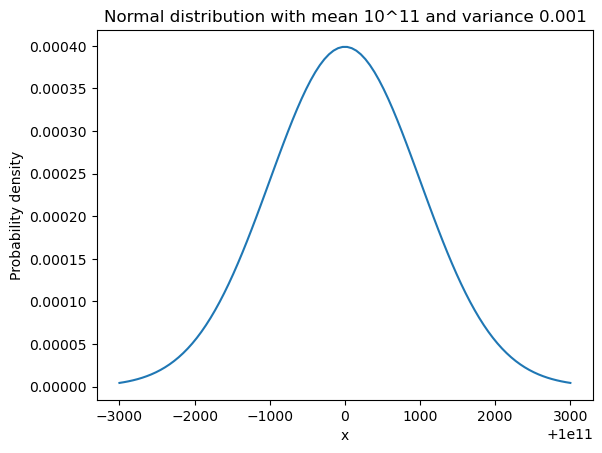

In [17]:
import numpy as np
import matplotlib.pyplot as plt

mean = 10**11
variance = 1000000

# Create a range of x-values
x = np.linspace(mean - 3*np.sqrt(variance), mean + 3*np.sqrt(variance), 100)

# Calculate the corresponding y-values from a Normal distribution
y = 1/np.sqrt(2*np.pi*variance) * np.exp(-(x-mean)**2/(2*variance))

# Plot the Normal distribution
plt.plot(x, y)
plt.title("Normal distribution with mean 10^11 and variance 0.001")
plt.xlabel("x")
plt.ylabel("Probability density")
plt.show()

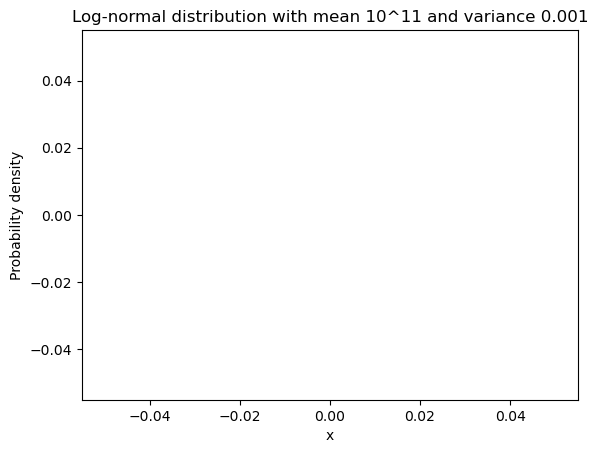

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

mean = 10**11
variance = 0.001

# Calculate the corresponding parameters for the log-normal distribution
sigma = np.sqrt(np.log(1 + variance/mean**2))
mu = np.log(mean) - 0.5*sigma**2

# Create a range of x-values
x = np.linspace(10**8, 10**12, 1000)

# Calculate the corresponding y-values from the log-normal distribution
y = lognorm.pdf(x, s=sigma, scale=np.exp(mu))

# Plot the log-normal distribution
plt.plot(x, y)
plt.title("Log-normal distribution with mean 10^11 and variance 0.001")
plt.xlabel("x")
plt.ylabel("Probability density")
plt.show()

In [11]:
y

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na